
### **Background:**


We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


We want to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.

### **Data:**

Our Data contains the 6 Quantitatives variables, 1 date type variable as shown below:

* **Open:** the price the stock opened at
* **High:** the highest price during the day
* **Low:** the lowest price during the day
* **Price:** the closing price on the trading day
* **Vol.:** Volume – how many shares were traded
* **changes %:** is the percentage of changes between the current day and the previous one.
* **Date:**The date.

**Goal(s):**

Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.

In [1]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import random
import datetime
import pmdarima as pm
import matplotlib as mpl
from pmdarima.arima import auto_arima
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, LeakyReLU
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading the dataset
xlsx = pd.ExcelFile("2020Q1Q2Q3Q4-2021Q1.xlsx",)

In [4]:

# The number of sheets in dictionary and the names of the sheets
print(f"Excel spreadsheet consists of {len(xlsx.sheet_names)} sheets")
print()
(xlsx.sheet_names)

Excel spreadsheet consists of 8 sheets



['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

### **Russia - Sberbank Rossii PAO (Sberbank):**

In [5]:
# read the sheet
Sberbank =pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", 0)

In [6]:
# Displaying first 5 observations
Sberbank.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294.0,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [7]:
# Displaying last 5 observations
Sberbank.tail()

,Date,Price,Open,High,Low,Vol.,Change %
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
310,2020-01-03 00:00:00,255.0,255.99,258.19,253.7,35.85M,0.0010
311,Highest: 296.07,Lowest: 172.15,Difference: 123.92,Average: 234.52,Change %: 14.24,NaN,NaN


In [8]:
# remove the last row as it contains a text
Sberbank.drop([Sberbank.shape[0]-1], axis=0, inplace=True)
Sberbank.tail()

,Date,Price,Open,High,Low,Vol.,Change %
306,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18.85M,0.0008
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
310,2020-01-03 00:00:00,255.0,255.99,258.19,253.7,35.85M,0.0010


In [9]:
#Rename the Vol. column to Volume
Sberbank.rename(columns = {'Vol.': 'Volume'}, inplace = True)
Sberbank.head()

,Date,Price,Open,High,Low,Volume,Change %
0,2021-03-31 00:00:00,291.02,294.0,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [10]:
# remove the (M)
Sberbank['Volume'] = Sberbank['Volume'].str.replace('M', '')

In [11]:
# fix the Date column data type to be in a date format instead of object
Sberbank[["Date"]] = Sberbank[["Date"]].apply(pd.to_datetime)
Sberbank

,Date,Price,Open,High,Low,Volume,Change %
0,2021-03-31,291.02,294.0,294.42,290.26,47.00,-0.0076
1,2021-03-30,293.25,294.86,295.72,291.5,38.81,-0.0002
2,2021-03-29,293.3,289.72,294.09,289.26,43.68,0.0071
3,2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159
4,2021-03-25,286.66,286.5,287.03,283.85,35.22,0.0030
...,...,...,...,...,...,...,...
306,2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008
307,2020-01-09,257.99,259.4,261.76,257.01,38.33,-0.0045
308,2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207
309,2020-01-06,253.9,254.75,254.84,251.4,22.35,-0.0043


In [12]:
# Sort Date values:
Sberbank = Sberbank.sort_values(by=['Date'], ascending=False)
Sberbank=Sberbank.set_index(['Date'])
Sberbank


,Price,Open,High,Low,Volume,Change %
Date,,,,,,
2021-03-31,291.02,294.0,294.42,290.26,47.00,-0.0076
2021-03-30,293.25,294.86,295.72,291.5,38.81,-0.0002
2021-03-29,293.3,289.72,294.09,289.26,43.68,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159
2021-03-25,286.66,286.5,287.03,283.85,35.22,0.0030
...,...,...,...,...,...,...
2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008
2020-01-09,257.99,259.4,261.76,257.01,38.33,-0.0045
2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207


In [13]:
Sberbank.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2021-03-31 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    object 
 1   Open      311 non-null    object 
 2   High      311 non-null    object 
 3   Low       311 non-null    object 
 4   Volume    311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(1), object(5)
memory usage: 17.0+ KB


In [14]:
# change the Price and other columns data type to int
Sberbank[["Price", "Open", "High", "Low", "Change %", 'Volume']] = Sberbank[["Price", "Open", "High", "Low", "Change %", 'Volume']].apply(pd.to_numeric)
Sberbank.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Volume      float64
Change %    float64
dtype: object

In [15]:
#Checking the missing values if there are any
Sberbank.isnull().sum()

Price       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64

### **Detecting Peaks and Troughs using zigzag indicator:**


The ZigZag indicator works by defining points as peaks and troughs if the distance between them passes a specific percentage threshold. To find these stationary points.

In [16]:
!pip install zigzag

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from zigzag import *


# call peak_valley_pivots:
pivots = peak_valley_pivots(Sberbank['Price'].values, 0.1, -0.1)

### **Plotting Time Series:**
### **Plot Sberbank price history:**

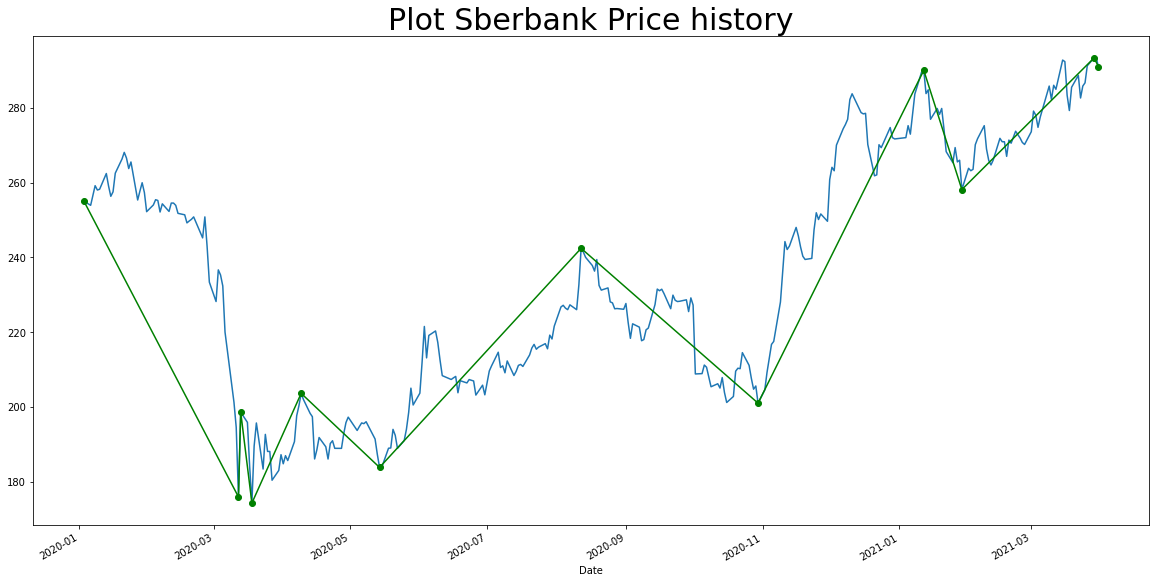

In [18]:
ts_pivots = pd.Series(Sberbank['Price'])
# plots the closing stock price as well
ts_pivots = ts_pivots[pivots != 0]
plt.figure(figsize=(20,10))
plt.title(f'Plot Sberbank Price history', fontsize=30); 
Sberbank['Price'].plot()
ts_pivots.plot(style='g-o');

From the plot above we noticed a significanthuge drop in the prices in the beginning, Afterwards, it started rising all the way to the end of the data.

### **Plot Sberbank Year-wise box history:**

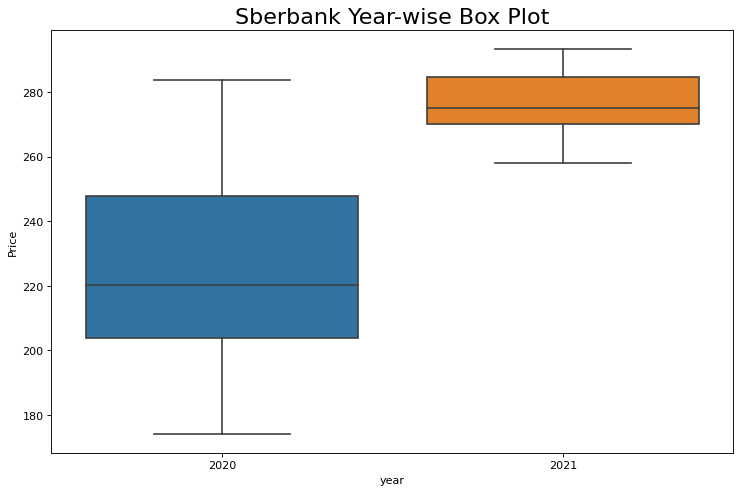

In [19]:
# first make a new columns for the months and the year
#add year column
Sberbank['year'] = [d.year for d in Sberbank.index]
years = Sberbank['year'].unique()

# Draw year_wise and month_wise box plots
plt.subplots(figsize=(11,7), dpi= 80)
sns.boxplot(x='year', y='Price', data=Sberbank)
plt.title(f'Sberbank Year-wise Box Plot', fontsize=20); 

From the Year-wise boxplot, the year of 2020 has a higher variance then the next year 2021.

### **Plot Sberbank Month-wise box history:**

Text(0.5, 1.0, 'Sberbank Month-wise box history')

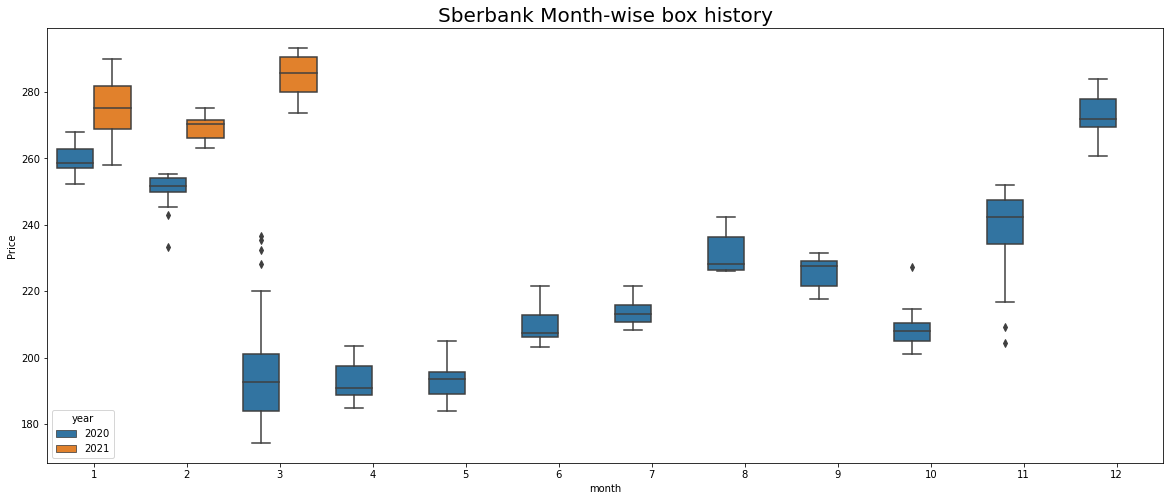

In [20]:
#add month column
Sberbank['month'] = [d.month for d in Sberbank.index]
months = Sberbank['month'].unique()

plt.figure(figsize=(20,8))
sns.boxplot(x='month', y='Price', data=Sberbank, hue='year')
plt.title(f'Sberbank Month-wise box history', fontsize=20)

From the month-wise boxplot, the months of March, November 2020 and January 2021 have higher variations in stock price comparing to other months.

### **Plot Price, High and Low history:**

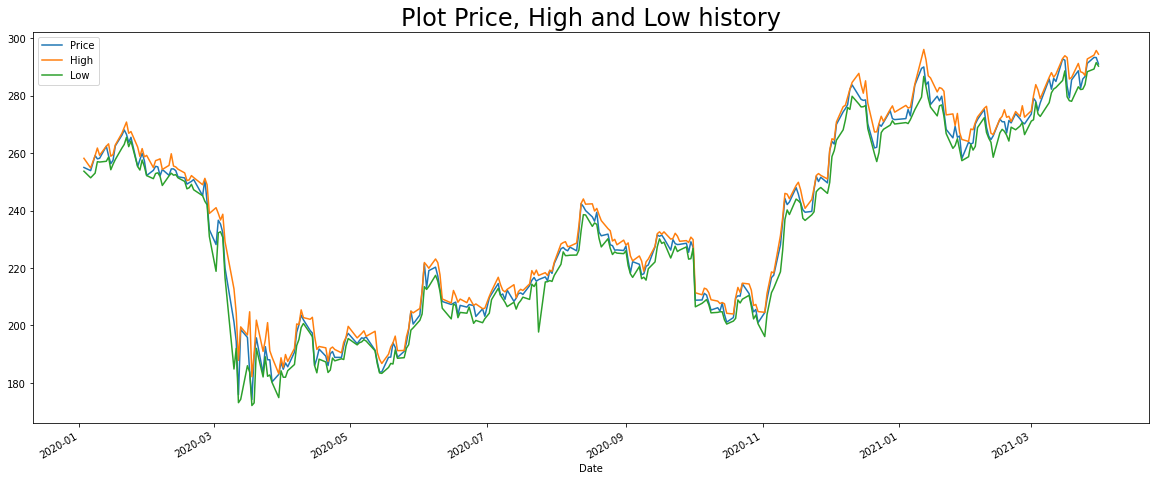

In [21]:
Sberbank[['Price','High','Low']].plot(figsize=(20,8))
plt.title('Plot Price, High and Low history', size=24)
plt.show()

### **Additive Decomposition:**

### **Time Series Decomposition:**
Since our objective is to forecast, I need to extract the components of the time series process for analysis. There are three major components for any time series process:

* **Trend:** gives a sense of the long-term direction of the time series and can be either upward, downward, or horizontal
* **Seasonality:** shows the repeated patterns over time.
* **Residuals:** is simply the remaining or unexplained portion once trend and seasonality are extracted.

The decomposition of a time series is the process of extracting the three components and representing them as their models. in this case we are going to use Addictive Decomposition (seasonal_decompose technique):

Additive: It is when the original model can be reconstructed by adding all three components and it is reasonable when the seasonal variations do not change over time.

$ y_t = T_t x S_t x R_t $


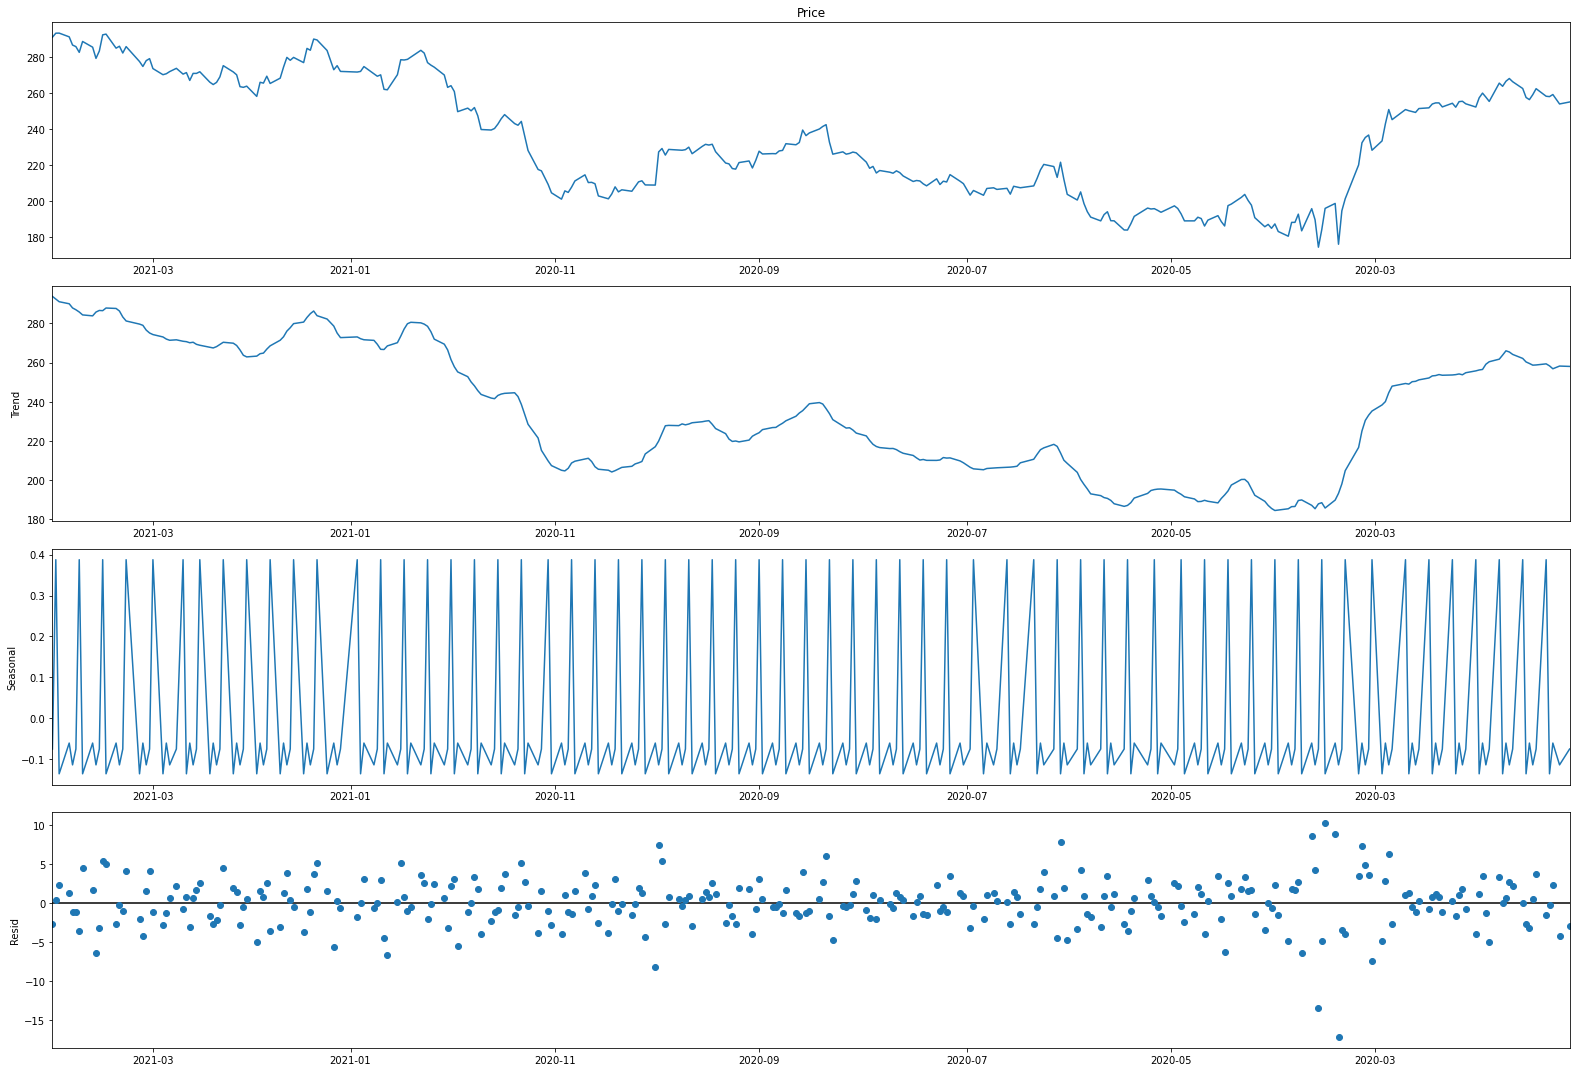

In [22]:
result_add = seasonal_decompose(Sberbank.Price, model='additive', extrapolate_trend='freq', period=5)
# Plot
plt.rcParams.update({'figure.figsize': (22,15)})
result_add.plot()
plt.show()

* **The 1st one:** is the original observed data that we are decomposing.
* **The trend component:** idicates whether there is positive, negative or constant long-term movement.
* **The seasonal component:** shows the seasonality effects on the repeating pattern of highs and lows.
* **The residual (noise) component:** shows the random variation in the data.

### **Augmented Dickey-Fuller test:**

The time series analysis only works with stationary data,I will be evaluating model stability over time using the Dickey-Fuller DF statistic test in order to determine whether the series is stationary ot not (The null hypothesis states that it is non-stationary).

One method for transforming the simplest non-stationary data is differencing. This process involves taking the differences of consecutive observations.

In [23]:
# ADF Test to fins the p-value
result = adfuller(Sberbank.Price.values, autolag='AIC')
if result[1] > 0.05:
        print(f'The original price values: \nThe time series is not stationary and the p-value is {result[1]}')
        result = adfuller(np.diff(Sberbank.Price.values), autolag='AIC')
if result[1] < 0.05:
        print(f'The price values after difference: \nThe time series is stationary and the p-value is {result[1]}')
        difference = Sberbank.Price.diff()
        Sberbank['difference'] = difference
else:
        print('Your time series is not stationary, you may need to make another difference')

The original price values: 
The time series is not stationary and the p-value is 0.35730124412210584
The price values after difference: 
The time series is stationary and the p-value is 4.395177575421608e-07


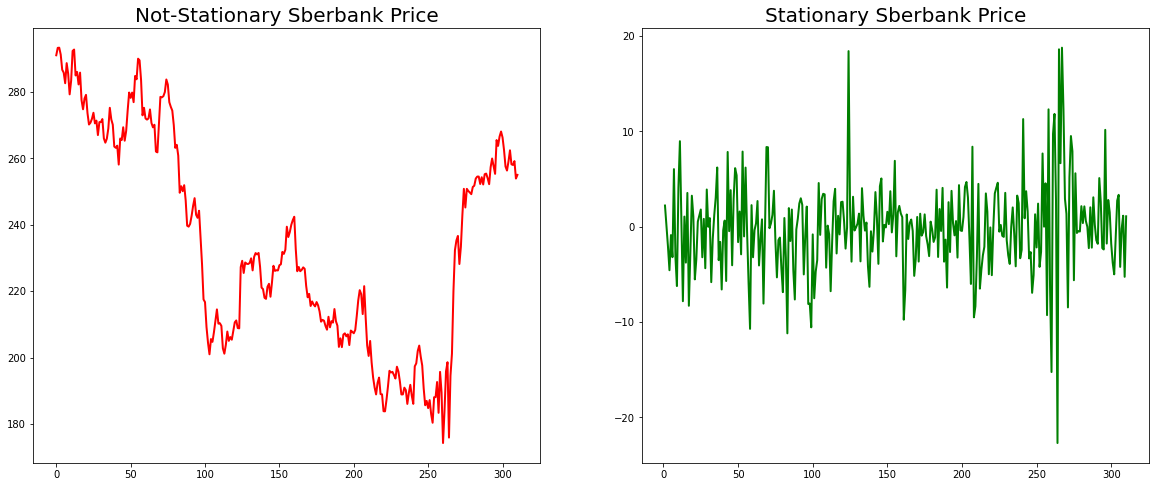

In [24]:
# Draw Plot
fig, axes = plt.subplots(1,2, figsize=(20,8))
pd.Series(Sberbank.Price.values).plot(title=f'Not-Stationary Sberbank Price', color='r', ax=axes[0], linewidth=2)
axes[0].title.set_size(20)
pd.Series(Sberbank.difference.values).plot(title=f'Stationary Sberbank Price', color='g', ax=axes[1], linewidth=2)
axes[1].title.set_size(20)

### **Split Data:**

In [25]:
# split the data to train, test datasets

Sberbank.fillna(Sberbank.mean(), inplace=True)
Sberbank1=Sberbank[['Price','Volume','Change %','difference']]
test = Sberbank1[Sberbank.index.astype(str).str.contains('2021')]
train = Sberbank1[Sberbank.index.astype(str).str.contains("2021") == False]

In [26]:
train.head()

,Price,Volume,Change %,difference
Date,,,,
2020-12-30,271.65,31.53,-0.0013,-0.35
2020-12-29,272.00,39.02,-0.0098,0.35
2020-12-28,274.70,39.04,0.0150,2.70
2020-12-25,270.64,11.99,0.0049,-4.06
2020-12-24,269.32,42.61,-0.0029,-1.32


In [27]:
test.head()

,Price,Volume,Change %,difference
Date,,,,
2021-03-31,291.02,47.00,-0.0076,-0.116194
2021-03-30,293.25,38.81,-0.0002,2.230000
2021-03-29,293.30,43.68,0.0071,0.050000
2021-03-26,291.22,56.07,0.0159,-2.080000
2021-03-25,286.66,35.22,0.0030,-4.560000


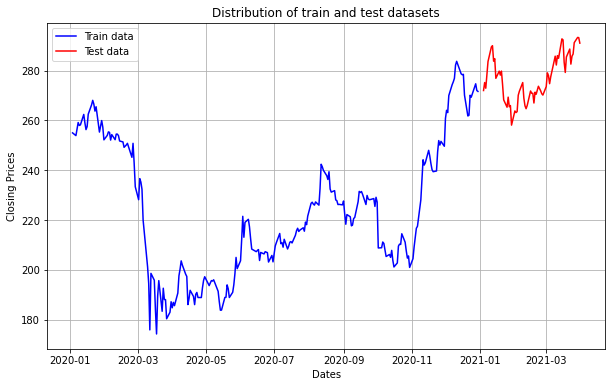

In [28]:
#plot the distribution of train and test
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train.Price, 'blue', label='Train data')
plt.plot(test.Price, 'red', label='Test data')
plt.title('Distribution of train and test datasets')
plt.legend()

### **Auto ARIMA:**

The Auto ARIMA automates the procedure for finding the optimal p, d, and q values which would be appropriate for the data set to provide better forecasting, Where:

Where,

* **p** is the order of the AR term. It refers to the number of lags of Y to be used as predictors. 

* **q** is the order of the MA term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

* **d** is the number of differencing required to make the time series stationary   

In [29]:
# create the model
AutoARIMA = auto_arima(train.Price, stepwise=False, trace=True)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1499.638, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1501.180, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1502.675, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1504.674, Time=0.15 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1498.792, Time=0.28 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1500.777, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1501.228, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1502.372, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1504.675, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1505.818, Time=0.31 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1500.782, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1502.533, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1504.526, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1498.601, Time=0.90 sec
 ARIMA(3,1,0)(0

In [30]:
print(AutoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -742.300
Date:                Wed, 14 Dec 2022   AIC                           1498.601
Time:                        22:56:36   BIC                           1523.223
Sample:                             0   HQIC                          1508.512
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1880      0.906     -0.207      0.836      -1.964       1.588
ar.L1         -1.1555      0.136     -8.507      0.000      -1.422      -0.889
ar.L2         -0.6724      0.111     -6.057      0.0

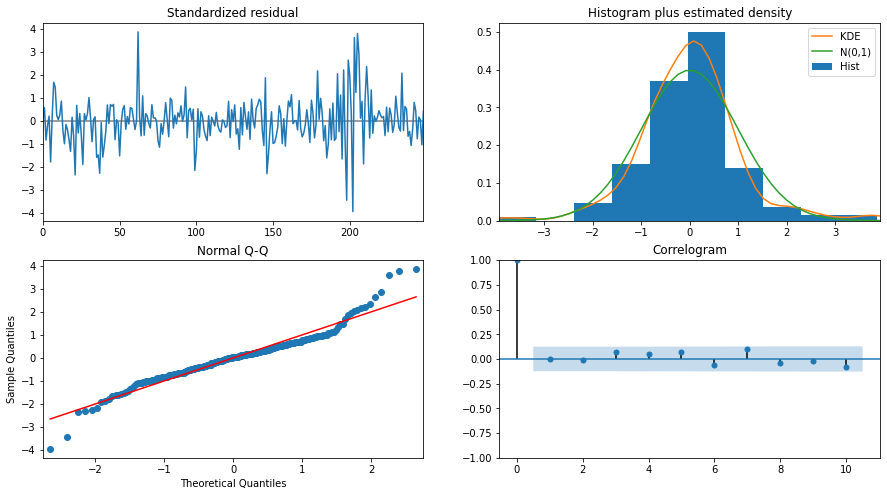

In [31]:
AutoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

The diagnostic plots concludes the following:

* Standardized residual plot: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.
* Normal Q-Q plot: The red line represents the normal distribution and when the data is perfectly aligned with it, it means it follows a normal distribution.
* The density plot: The density plot on the top right suggests a normal distribution with a mean of zero.
* The correlogram plot: The residual errors are not autocorrelated. The bars doesn't go above the significance threshold which means the prices aren't highly correlated.

In [32]:
# best model parameters
AutoARIMA.order

(2, 1, 3)

The best model is ARIMA (p=2,d=1,q=3)

### **Deep learning model LSTM:**

In [33]:
SBER_df=Sberbank[["Price"]]
SBER_df =SBER_df.sort_index()
SBER_df =SBER_df.rolling(7).mean().dropna()
SBER_df.head()

,Price
Date,
2020-01-14,257.954286
2020-01-15,258.141429
2020-01-16,258.657143
2020-01-17,259.135714
2020-01-20,260.320000


In [34]:
def Lookback_data(df, lookback):
    data_raw = df.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback + 1])
    data = np.array(data)
    
    X = data [:, :-1, :].reshape(len(data), 5)
    y = data[:, -1, 0].reshape(-1,1)
    
    
    df_featured = pd.DataFrame(X)
    df_featured['y'] = y
    df_featured.set_index(df.index[lookback:], inplace = True)
    return df_featured

In [35]:
SBER_df_featured =Lookback_data(SBER_df,5)
SBER_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-21,257.954286,258.141429,258.657143,259.135714,260.320000,261.730000
2020-01-22,258.141429,258.657143,259.135714,260.320000,261.730000,262.321429
2020-01-23,258.657143,259.135714,260.320000,261.730000,262.321429,262.990000
2020-01-24,259.135714,260.320000,261.730000,262.321429,262.990000,264.301429
2020-01-27,260.320000,261.730000,262.321429,262.990000,264.301429,263.988571


### **Split Dataset:**

In [36]:
train_ratio = 0.7
validation_ratio = 0.1

train_ratio +validation_ratio <= 0.8  # Train + validation ratio shold be less than or equal to 0.8
train_size =int(len(SBER_df_featured) *train_ratio)
val_size =int(len(SBER_df_featured) *validation_ratio)
test_size = len(SBER_df_featured) -train_size-val_size


train, val, test = SBER_df_featured.iloc[0:train_size,:], SBER_df_featured.iloc[train_size: train_size + val_size,:]  ,\
                SBER_df_featured.iloc[train_size+val_size:len(SBER_df_featured),:]

In [37]:
train.shape, test.shape, val.shape

((210, 6), (60, 6), (30, 6))

**Scaling:**

In [38]:
scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]

### **Split dataset into train, validation & test:**

In [39]:
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

### **Modeling:**

In [40]:
callbacks=[
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, min_delta = 0.00000000001, verbose=1),
    ModelCheckpoint("model.h5", verbose=1, save_best_only=True, save_weights_only=True)
]

In [41]:
model = Sequential()
model.add(LSTM(100,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(100, return_sequences=True, activation="relu"))
model.add(LSTM(100))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.1914
Epoch 1: val_loss improved from inf to 0.66203, saving model to model.h5
7/7 [==============================] - 12s 394ms/step - loss: 0.1914 - val_loss: 0.6620 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0798
Epoch 2: val_loss improved from 0.66203 to 0.10449, saving model to model.h5
7/7 [==============================] - 0s 45ms/step - loss: 0.0798 - val_loss: 0.1045 - lr: 0.0010
Epoch 3/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0555
Epoch 3: val_loss improved from 0.10449 to 0.09214, saving model to model.h5
7/7 [==============================] - 0s 36ms/step - loss: 0.0529 - val_loss: 0.0921 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0317
Epoch 4: val_loss did not improve from 0.09214
7/7 [==============================] - 0s 33ms/step - loss: 0.0317 - val_loss: 0.1583 - lr: 0.0010
Epoch 5/100
7/7 [===============

In [43]:
def plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict):
    fig =plt.figure(figsize = (30,10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
   
    # Plotting training data
    plt.subplot(1,3,1)
    ax = sns.lineplot(x =np.arange(0,len(y_train)), y=y_train, label="Date", color="royalblue")
    ax =sns.lineplot(x =np.arange(0, len(y_train)), y =y_train_predict.reshape(-1),
                     label="Training Prediction (LSTM)", color="tomato")
    ax.set_title("Stock price", size=14 , fontweight= "bold")
    ax.set_xlabel("Days", size=14)
    ax.set_ylabel("Cost (USD $)", size=14)
    ax.set_xticklabels("", size=10)
    
    #ploting for Validation data
    plt.subplot(1,3,2)
    ax = sns.lineplot(x =np.arange(0,len(y_val)), y=y_val, label="Date", color="royalblue")
    ax =sns.lineplot(x =np.arange(0, len(y_val)), y =y_val_predict.reshape(-1),
                     label="Validation Data Prediction (LSTM)", color="tomato")
    ax.set_title("Stock price", size=14 , fontweight= "bold")
    ax.set_xlabel("Days", size=14)
    ax.set_ylabel("Cost (USD $)", size=14)
    ax.set_xticklabels("", size=10)
    
    #ploting for Test data
    plt.subplot(1,3,3)
    ax = sns.lineplot(x =np.arange(0,len(y_test)), y=y_test, label="Date", color="royalblue")
    ax =sns.lineplot(x =np.arange(0, len(y_test)), y =y_test_predict.reshape(-1),
                     label="Test Data Prediction (LSTM)", color="tomato")
    ax.set_title("Stock price", size=14 , fontweight= "bold")
    ax.set_xlabel("Days", size=14)
    ax.set_ylabel("Cost (USD $)", size=14)
    ax.set_xticklabels("", size=10)
    
    plt.show()

2/2 [==============================] - 0s 7ms/step


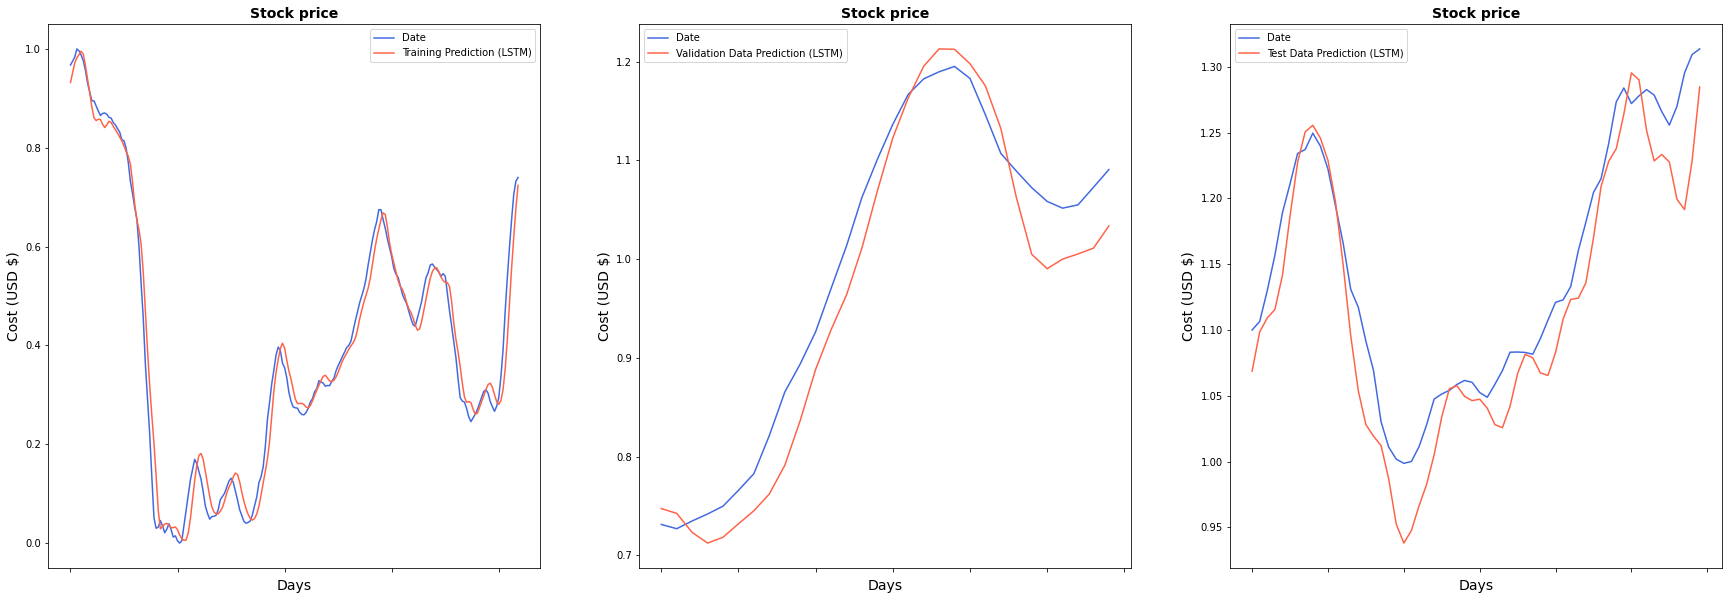

In [44]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)

plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

In [45]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])

In [46]:
def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    prediction_inverse = scaler.inverse_transform(predictions)
    return prediction_inverse

In [47]:
pred_prices = scaler_inverse(train_array=train["y"].values,
                            predictions=predictions)

In [48]:
def bollinger_bands(df, days):
    df['rolling_avg'] = df['predicted'].rolling(days).mean()
    df['rolling_std'] = df['predicted'].rolling(days).std()
    df['Upper Band']  = df['rolling_avg'] + (df['rolling_std'] * 2)
    df['Lower Band']  = df['rolling_avg'] - (df['rolling_std'] * 2)
    df = df.dropna()
    return df

In [49]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1,len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [50]:
def plot_bb_strategy(df, buy_price, sell_price):
    #plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (20, 10)
    df['predicted'].plot(label = 'PREDICTED PRICES', alpha = 0.3)
    df['Upper Band'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'red')
    df['rolling_avg'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
    df['Lower Band'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'red')
    plt.scatter(df.index[1:], buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    plt.scatter(df.index[1:], sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.title('Bollinger Bands')
    plt.legend(loc = 'upper left')
    plt.show()


In [51]:
def capital_gain_predicted_prices(df1, df2):
    # Define the total capital gain as the final value minus the initial value divided by the initial value
    actual_returns = (df1.iloc[-1] - df1.iloc[0])/df1.iloc[0]
    # Predicted returns 
    predicted_returns = (df2.iloc[-1] - df2.iloc[0])/df2.iloc[0]
    # Show the value as percentage
    actual_returns = round(actual_returns*100,2)
    predicted_returns = round(predicted_returns*100, 2)
    print('The actual returns had a value of {}% and the predicted returns had a value {}%'.format(actual_returns, 
                                                                                                predicted_returns))

In [52]:
def Bollinger_band_strategy(actuals, predictions, days):
    pred_df = pd.DataFrame(predictions)
    pred_df.columns = ['predicted']
    pred_df['actuals'] = actuals
    pred_df = bollinger_bands(pred_df, days)
    
    pred_df = pred_df.reset_index(drop=True)
    
    display(pred_df.head())
    buy_price, sell_price, bb_signal = \
    implement_bb_strategy(pred_df['predicted'], pred_df['Lower Band'], pred_df['Upper Band'])
    
    plot_bb_strategy(pred_df, buy_price, sell_price )
    
    
    pred_df = pred_df.iloc[1:].reset_index(drop=True)
    pred_df['bb_signal'] = bb_signal
    
    
    capital_gain_predicted_prices(df1 = pred_df['actuals'], df2 = pred_df['predicted'])
    
    return pred_df

,predicted,actuals,rolling_avg,rolling_std,Upper Band,Lower Band
0,252.515106,253.222857,257.092402,4.664103,266.420608,247.764196
1,251.890610,252.494286,256.741026,4.782531,266.306088,247.175965
2,251.351974,252.128571,256.285473,4.842886,265.971244,246.599702
3,250.816208,251.507143,255.724498,4.791281,265.307060,246.141936
4,250.174408,250.978571,255.089743,4.633205,264.356153,245.823333


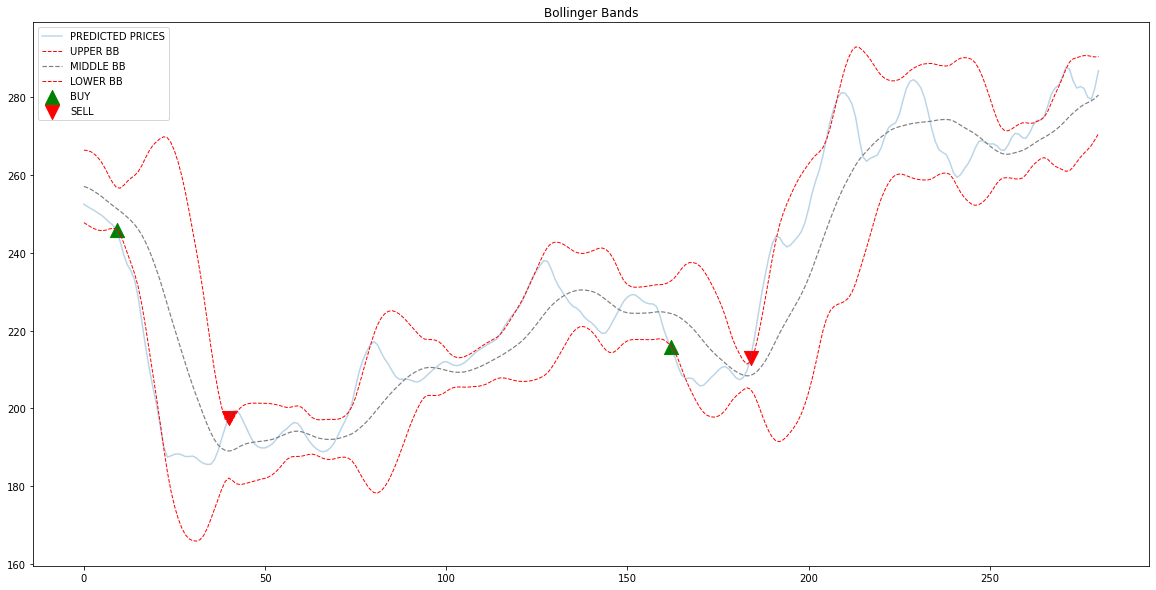

The actual returns had a value of 14.51% and the predicted returns had a value 13.87%


In [53]:
actuals=SBER_df_featured["y"].values
Bollinger_band = Bollinger_band_strategy(actuals, pred_prices, 20)

### **Turkey - Koc Holding AS (KCHOL):**

In [54]:
KCHOL =pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", 1)
KCHOL.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,19.41,19.42,19.63,19.27,13.14M,-0.0046
1,2021-03-30 00:00:00,19.5,19.12,19.81,19.03,21.05M,0.0209
2,2021-03-29 00:00:00,19.1,19.24,19.67,19.1,16.56M,-0.0078
3,2021-03-26 00:00:00,19.25,20.28,20.36,19.1,21.35M,-0.0385
4,2021-03-25 00:00:00,20.02,20.5,20.86,20.02,15.93M,-0.0148


In [55]:
KCHOL.tail()

,Date,Price,Open,High,Low,Vol.,Change %
311,2020-01-07 00:00:00,19.93,20.22,20.28,19.92,2.89M,-0.0075
312,2020-01-06 00:00:00,20.08,20.34,20.34,19.97,1.94M,-0.0108
313,2020-01-03 00:00:00,20.3,20.3,20.44,19.97,3.31M,-0.0039
314,2020-01-02 00:00:00,20.38,20.42,20.44,20.24,2.53M,0.0030
315,Highest: 25.48,Lowest: 12.38,Difference: 13.10,Average: 17.86,Change %: -4.48,NaN,NaN


In [56]:
# Drop the last row
KCHOL = KCHOL.iloc[:-1]
KCHOL.tail()

,Date,Price,Open,High,Low,Vol.,Change %
310,2020-01-08 00:00:00,19.94,19.89,19.95,19.66,2.79M,0.0005
311,2020-01-07 00:00:00,19.93,20.22,20.28,19.92,2.89M,-0.0075
312,2020-01-06 00:00:00,20.08,20.34,20.34,19.97,1.94M,-0.0108
313,2020-01-03 00:00:00,20.3,20.3,20.44,19.97,3.31M,-0.0039
314,2020-01-02 00:00:00,20.38,20.42,20.44,20.24,2.53M,0.0030


In [57]:
KCHOL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      315 non-null    object 
 1   Price     315 non-null    object 
 2   Open      315 non-null    object 
 3   High      315 non-null    object 
 4   Low       315 non-null    object 
 5   Vol.      315 non-null    object 
 6   Change %  315 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.4+ KB


In [58]:
# Removeletter "M" from Vol. variable
KCHOL['Vol.'] = KCHOL['Vol.'].str.replace('M','')
KCHOL.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,19.41,19.42,19.63,19.27,13.14,-0.0046
1,2021-03-30 00:00:00,19.5,19.12,19.81,19.03,21.05,0.0209
2,2021-03-29 00:00:00,19.1,19.24,19.67,19.1,16.56,-0.0078
3,2021-03-26 00:00:00,19.25,20.28,20.36,19.1,21.35,-0.0385
4,2021-03-25 00:00:00,20.02,20.5,20.86,20.02,15.93,-0.0148


In [59]:
# Rename column from Vol. to Volume
KCHOL.rename(columns={'Vol.':'Volume'}, inplace=True)

In [60]:
# Parsing the index to a datetimeindex
KCHOL["Date"] = pd.to_datetime(KCHOL["Date"])

In [61]:
KCHOL.sort_index(ascending=True, inplace=True)
KCHOL.set_index("Date", inplace=True)
KCHOL.head()

,Price,Open,High,Low,Volume,Change %
Date,,,,,,
2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046
2021-03-30,19.5,19.12,19.81,19.03,21.05,0.0209
2021-03-29,19.1,19.24,19.67,19.1,16.56,-0.0078
2021-03-26,19.25,20.28,20.36,19.1,21.35,-0.0385
2021-03-25,20.02,20.5,20.86,20.02,15.93,-0.0148


In [62]:
KCHOL[["Price", "Open", "High", "Low", 'Volume',"Change %"]] = KCHOL[["Price", "Open", "High", "Low", 'Volume',"Change %"]].apply(pd.to_numeric)
KCHOL.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Volume      float64
Change %    float64
dtype: object

In [63]:
KCHOL.isnull().sum()

Price       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64

### **Plotting Time Series:**
### **Plot KOC Holding AS price history:**


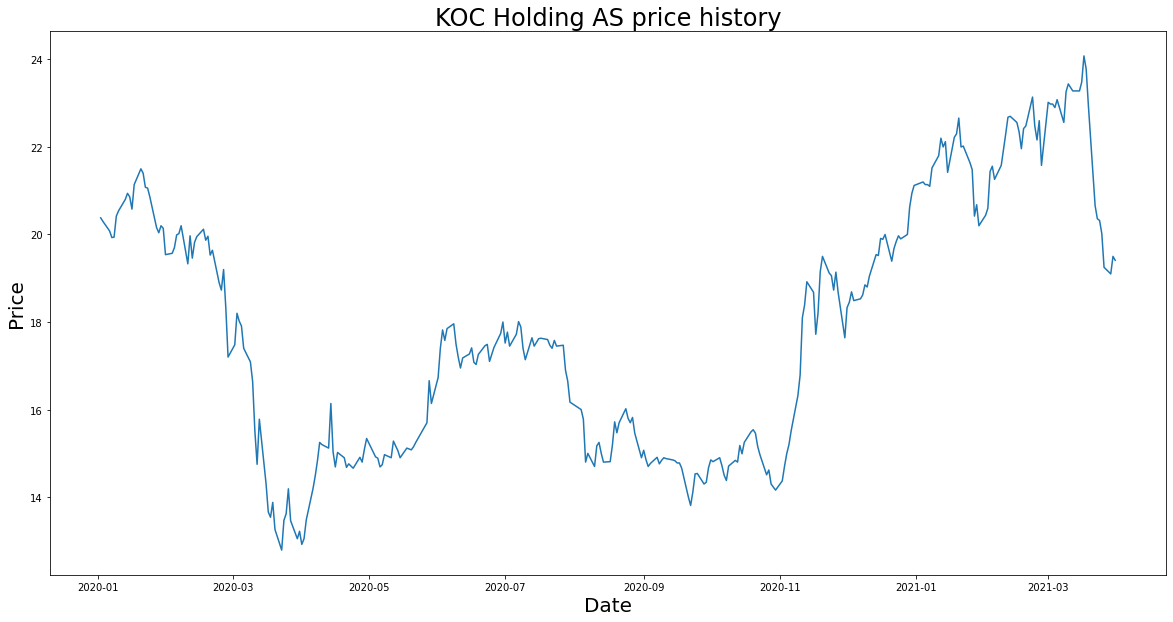

In [64]:
# Line plot of the Price variable
plt.plot(KCHOL.index, KCHOL['Price'])
plt.xlabel("Date", size=20)
plt.ylabel("Price", size=20)
plt.title("KOC Holding AS price history", size=24)
plt.show()

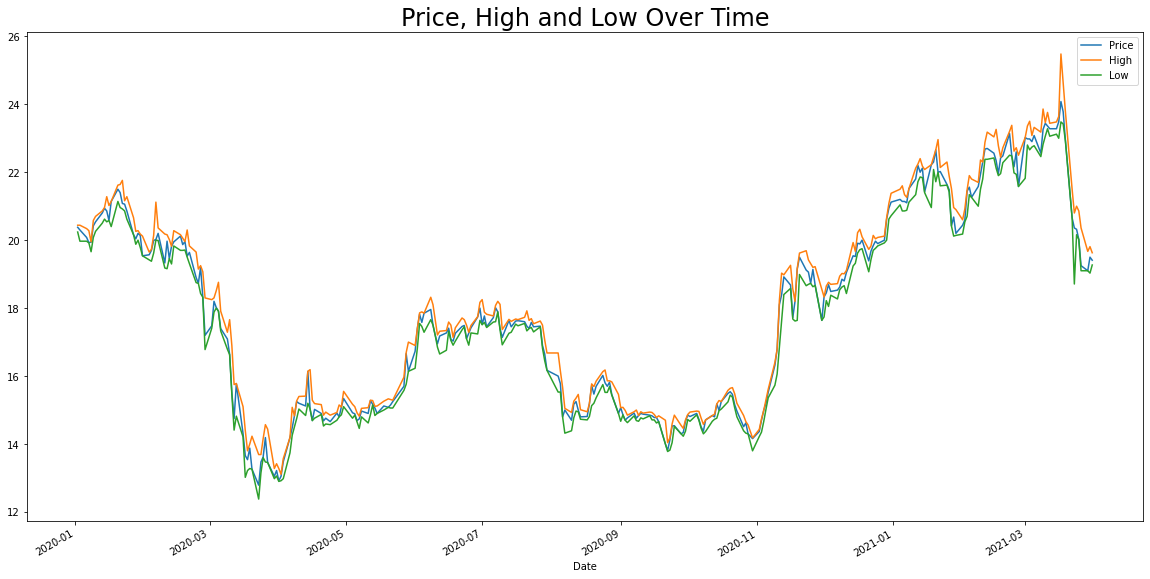

In [65]:
# Line plot of rthe Price, High and Low variables in koc
KCHOL[['Price','High','Low']].plot()
plt.title("Price, High and Low Over Time", size=24)
plt.show()

### **Plot KOC Holding AS Year-wise box history:**

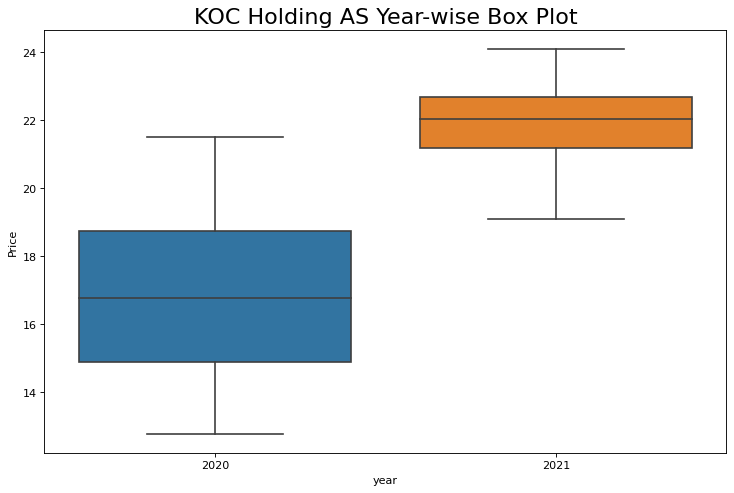

In [66]:
# first make a new columns for the months and the year
#add year column
KCHOL['year'] = [d.year for d in KCHOL.index]
years = KCHOL['year'].unique()

# Draw year_wise and month_wise box plots
plt.subplots(figsize=(11,7), dpi= 80)
sns.boxplot(x='year', y='Price', data=KCHOL)
plt.title(f'KOC Holding AS Year-wise Box Plot', fontsize=20); 

### **Plot KOC Holding AS Month-wise box history:**

Text(0.5, 1.0, 'KOC Holding AS Month-wise box history')

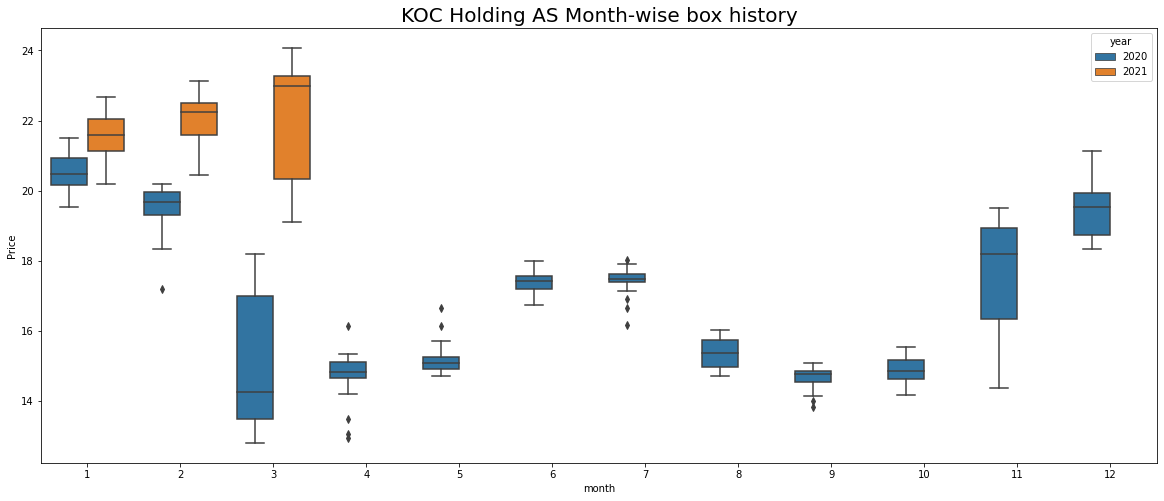

In [67]:
#add month column
KCHOL['month'] = [d.month for d in KCHOL.index]
months = KCHOL['month'].unique()

plt.figure(figsize=(20,8))
sns.boxplot(x='month', y='Price', data=KCHOL, hue='year')
plt.title(f'KOC Holding AS Month-wise box history', fontsize=20)

### **Additive Decomposition:**

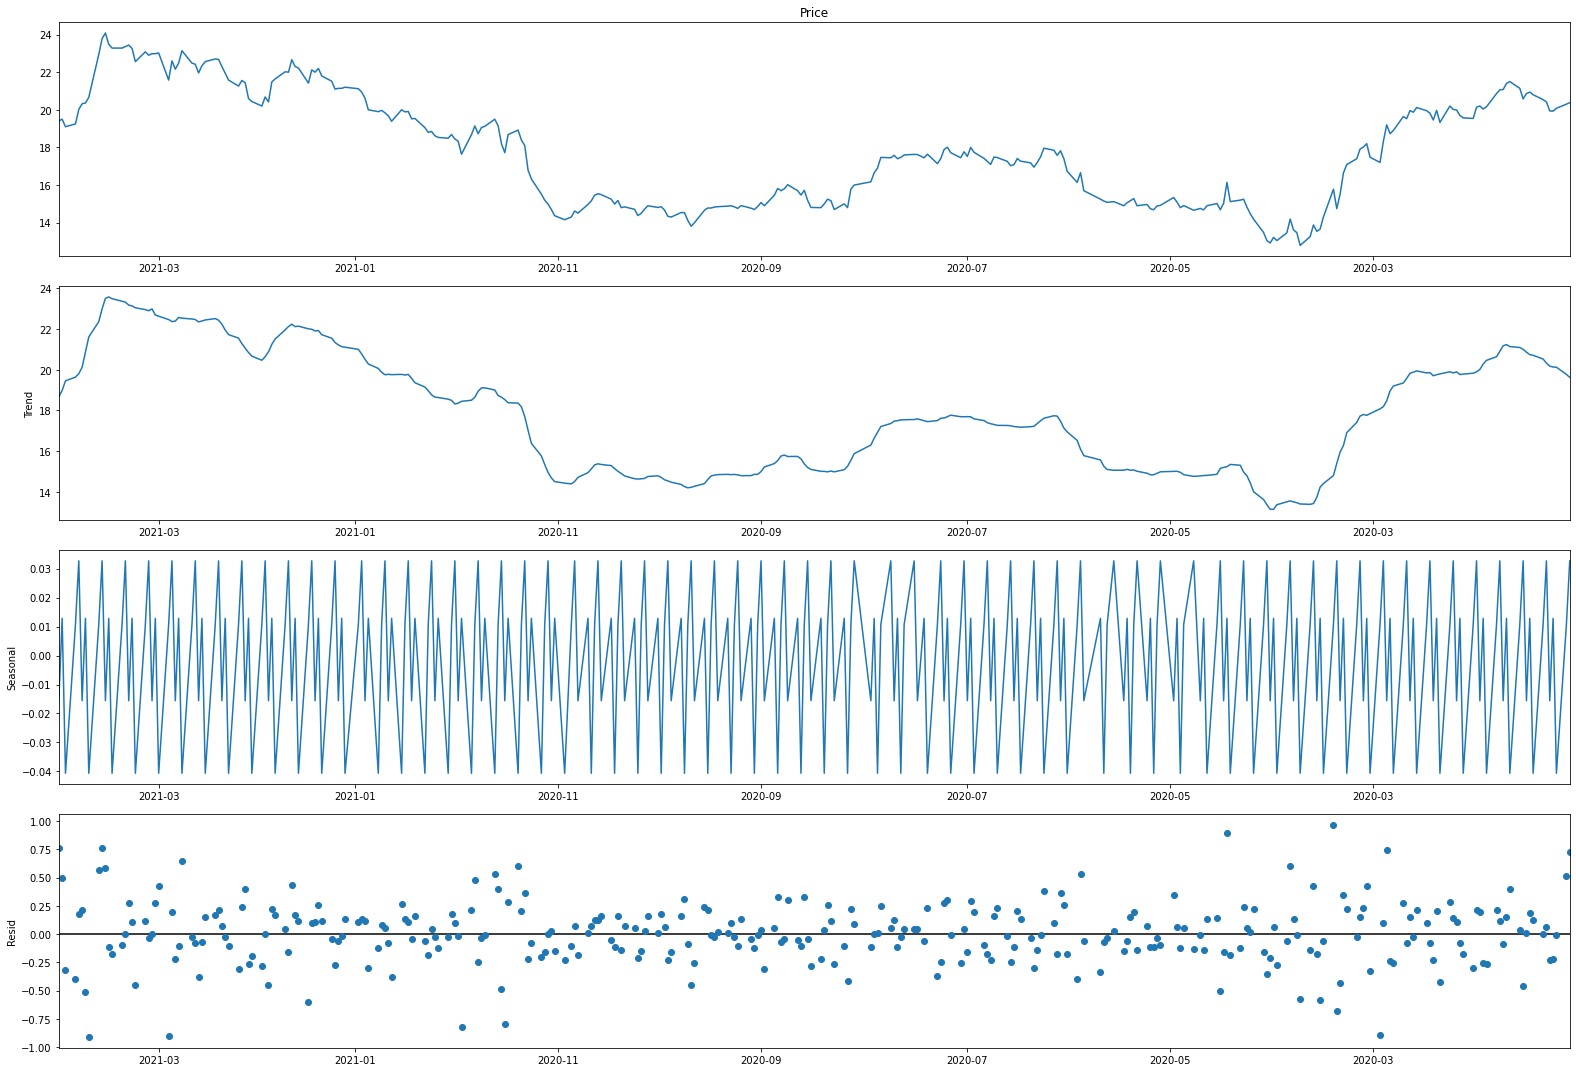

In [68]:
result = seasonal_decompose(KCHOL.Price, model='additive', extrapolate_trend='freq', period=5)
# Plot
plt.rcParams.update({'figure.figsize': (22,15)})
result.plot()
plt.show()

### **Augmented Dickey-Fuller test:**

In [69]:
# ADF Test to fins the p-value
result = adfuller(KCHOL.Price.values, autolag='AIC')
if result[1] > 0.05:
        print(f'The original price values: \nThe time series is not stationary and the p-value is {result[1]}')
        result = adfuller(np.diff(KCHOL.Price.values), autolag='AIC')
if result[1] < 0.05:
        print(f'The price values after difference: \nThe time series is stationary and the p-value is {result[1]}')
        difference = KCHOL.Price.diff()
        KCHOL['difference'] = difference
else:
        print('Your time series is not stationary, you may need to make another difference')

The original price values: 
The time series is not stationary and the p-value is 0.6615309995716299
The price values after difference: 
The time series is stationary and the p-value is 8.19472533124018e-30


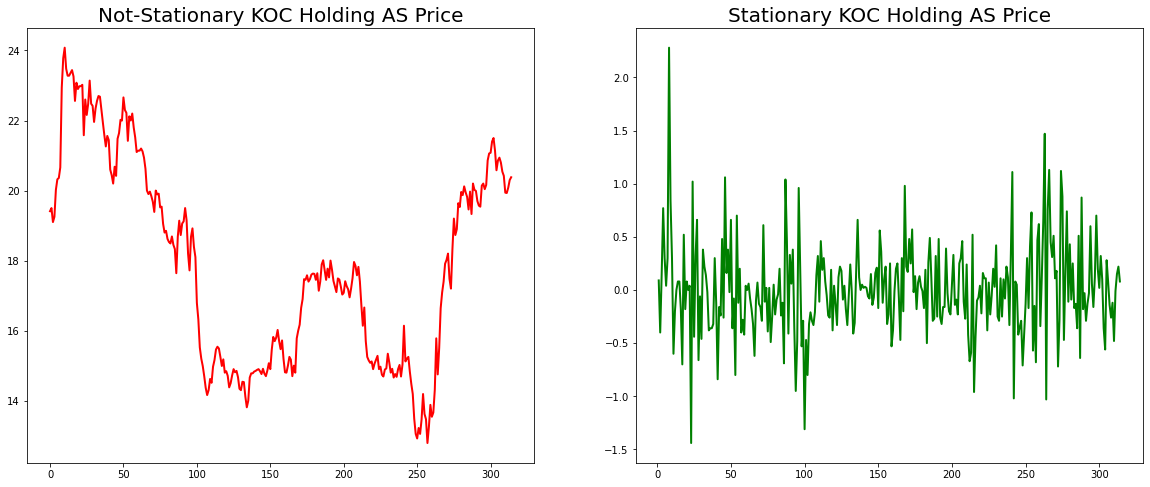

In [70]:
# Draw Plot
fig, axes = plt.subplots(1,2, figsize=(20,8))
pd.Series(KCHOL.Price.values).plot(title=f'Not-Stationary KOC Holding AS Price', color='r', ax=axes[0], linewidth=2)
axes[0].title.set_size(20)
pd.Series(KCHOL.difference.values).plot(title=f'Stationary KOC Holding AS Price', color='g', ax=axes[1], linewidth=2)
axes[1].title.set_size(20)

### **Split Data:**

In [71]:
# split the data to train, test datasets

KCHOL.fillna(KCHOL.mean(), inplace=True)
KCHOL1=KCHOL[['Price','Volume','Change %','difference']]
test = KCHOL1[KCHOL.index.astype(str).str.contains('2021')]
train = KCHOL1[KCHOL.index.astype(str).str.contains("2021") == False]

In [72]:
train.head()

,Price,Volume,Change %,difference
Date,,,,
2020-12-31,21.12,7.12,0.0086,-0.08
2020-12-30,20.94,10.05,0.0155,-0.18
2020-12-29,20.62,9.93,0.0310,-0.32
2020-12-28,20.00,4.68,0.0050,-0.62
2020-12-25,19.90,2.94,-0.0035,-0.10


In [73]:
test.head()

,Price,Volume,Change %,difference
Date,,,,
2021-03-31,19.41,13.14,-0.0046,0.003089
2021-03-30,19.50,21.05,0.0209,0.090000
2021-03-29,19.10,16.56,-0.0078,-0.400000
2021-03-26,19.25,21.35,-0.0385,0.150000
2021-03-25,20.02,15.93,-0.0148,0.770000


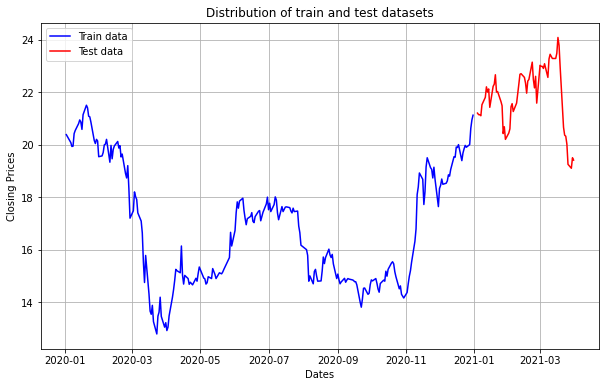

In [74]:
#plot the distribution of train and test
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train.Price, 'blue', label='Train data')
plt.plot(test.Price, 'red', label='Test data')
plt.title('Distribution of train and test datasets')
plt.legend()

### **Auto ARIMA:**

In [75]:
# create the model
ARIMA = auto_arima(train.Price, stepwise=False, trace=True)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=254.949, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=256.238, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=258.020, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=258.911, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=254.725, Time=0.18 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=256.060, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=256.283, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=257.994, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=258.660, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=256.721, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=256.068, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=258.065, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=259.907, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=258.355, Time=0.79 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=252.959, Time=0.79 sec
 ARIMA(3,1,0)(0,0,0)[1] i

In [76]:
print(ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -119.479
Date:                Wed, 14 Dec 2022   AIC                            252.959
Time:                        22:57:20   BIC                            277.637
Sample:                             0   HQIC                           262.890
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0011      0.010     -0.108      0.914      -0.021       0.018
ar.L1          1.5689      0.052     30.432      0.000       1.468       1.670
ar.L2         -0.8840      0.055    -16.153      0.0

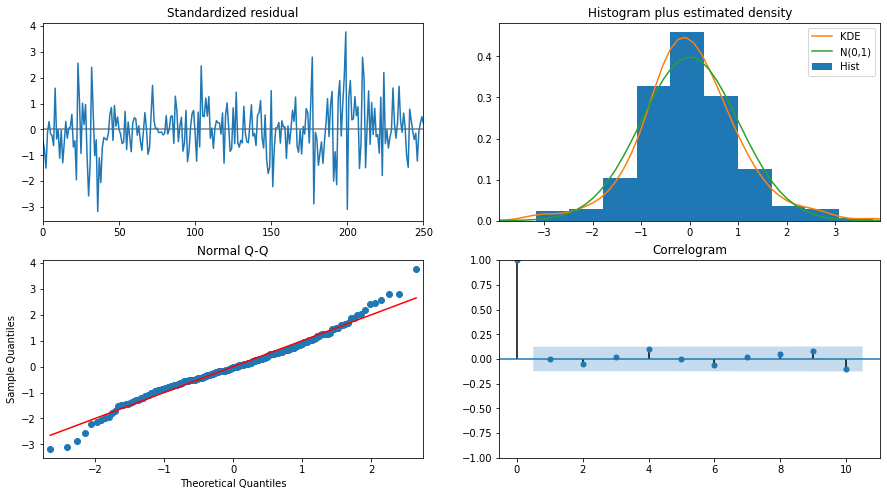

In [77]:
ARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [78]:
# best model parameters
ARIMA.order

(2, 1, 3)

### **Deep learning model LSTM:**

In [79]:
KCHOL_df=KCHOL[["Price"]]
KCHOL_df =KCHOL_df.sort_index()
KCHOL_df =KCHOL_df.rolling(7).mean().dropna()
KCHOL_df.head()

,Price
Date,
2020-01-10,20.227143
2020-01-13,20.287143
2020-01-14,20.378571
2020-01-15,20.490000
2020-01-16,20.582857


In [80]:
KCHOL_df_featured =Lookback_data(KCHOL_df,5)
KCHOL_df_featured.head()

,0,1,2,3,4,y
Date,,,,,,
2020-01-17,20.227143,20.287143,20.378571,20.490000,20.582857,20.754286
2020-01-20,20.287143,20.378571,20.490000,20.582857,20.754286,20.908571
2020-01-21,20.378571,20.490000,20.582857,20.754286,20.908571,21.031429
2020-01-22,20.490000,20.582857,20.754286,20.908571,21.031429,21.071429
2020-01-23,20.582857,20.754286,20.908571,21.031429,21.071429,21.088571


### **Split Dataset:**

In [81]:
train_ratio = 0.7
validation_ratio = 0.1

train_ratio +validation_ratio <= 0.8  # Train + validation ratio shold be less than or equal to 0.8
train_size =int(len(KCHOL_df_featured) *train_ratio)
val_size =int(len(KCHOL_df_featured) *validation_ratio)
test_size = len(KCHOL_df_featured) -train_size-val_size


train, val, test = KCHOL_df_featured.iloc[0:train_size,:], KCHOL_df_featured.iloc[train_size: train_size + val_size,:]  ,\
                KCHOL_df_featured.iloc[train_size+val_size:len(KCHOL_df_featured),:]

In [82]:
train.shape, test.shape, val.shape

((212, 6), (62, 6), (30, 6))

### **Scaling:**

In [83]:
scaler =MinMaxScaler(feature_range=(0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
val_scaled =pd.DataFrame(scaler.transform(val[val.columns]))
test_scaled =pd.DataFrame(scaler.transform(test[test.columns]))


train_scaled.columns =["day1","day2", "day3", "day4", "day5", "y"]
val_scaled.columns=["day1","day2", "day3", "day4", "day5", "y"]
test_scaled.columns = ["day1","day2", "day3", "day4", "day5", "y"]

In [84]:
# Training
X_train =train_scaled.drop("y", axis=1).values
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train =train_scaled["y"].values

# Validation
X_val =val_scaled.drop("y", axis=1).values
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val =val_scaled["y"].values

# Test
X_test =test_scaled.drop("y", axis=1).values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test =test_scaled["y"].values

### **Modeling:**

In [85]:
callbacks=[
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, min_delta = 0.00000000001, verbose=1),
    ModelCheckpoint("model.h6", verbose=1, save_best_only=True, save_weights_only=True)
]

In [86]:
model = Sequential()
model.add(LSTM(100,return_sequences=True,activation="relu", input_shape=(5,1)))
model.add(LSTM(100, return_sequences=True, activation="relu"))
model.add(LSTM(100))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 100)            40800     
                                                                 
 lstm_4 (LSTM)               (None, 5, 100)            80400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train , epochs=100, batch_size= 32, 
         validation_data = (X_val, y_val),
         callbacks=callbacks)

Epoch 1/100
5/7 [====================>.........] - ETA: 0s - loss: 0.2151 
Epoch 1: val_loss improved from inf to 0.38517, saving model to model.h6
7/7 [==============================] - 5s 147ms/step - loss: 0.1905 - val_loss: 0.3852 - lr: 0.0010
Epoch 2/100
5/7 [====================>.........] - ETA: 0s - loss: 0.0902
Epoch 2: val_loss improved from 0.38517 to 0.06266, saving model to model.h6
7/7 [==============================] - 0s 22ms/step - loss: 0.0856 - val_loss: 0.0627 - lr: 0.0010
Epoch 3/100
4/7 [================>.............] - ETA: 0s - loss: 0.0521
Epoch 3: val_loss improved from 0.06266 to 0.02427, saving model to model.h6
7/7 [==============================] - 0s 23ms/step - loss: 0.0532 - val_loss: 0.0243 - lr: 0.0010
Epoch 4/100
4/7 [================>.............] - ETA: 0s - loss: 0.0354
Epoch 4: val_loss did not improve from 0.02427
7/7 [==============================] - 0s 19ms/step - loss: 0.0341 - val_loss: 0.0895 - lr: 0.0010
Epoch 5/100
4/7 [===============

2/2 [==============================] - 0s 11ms/step


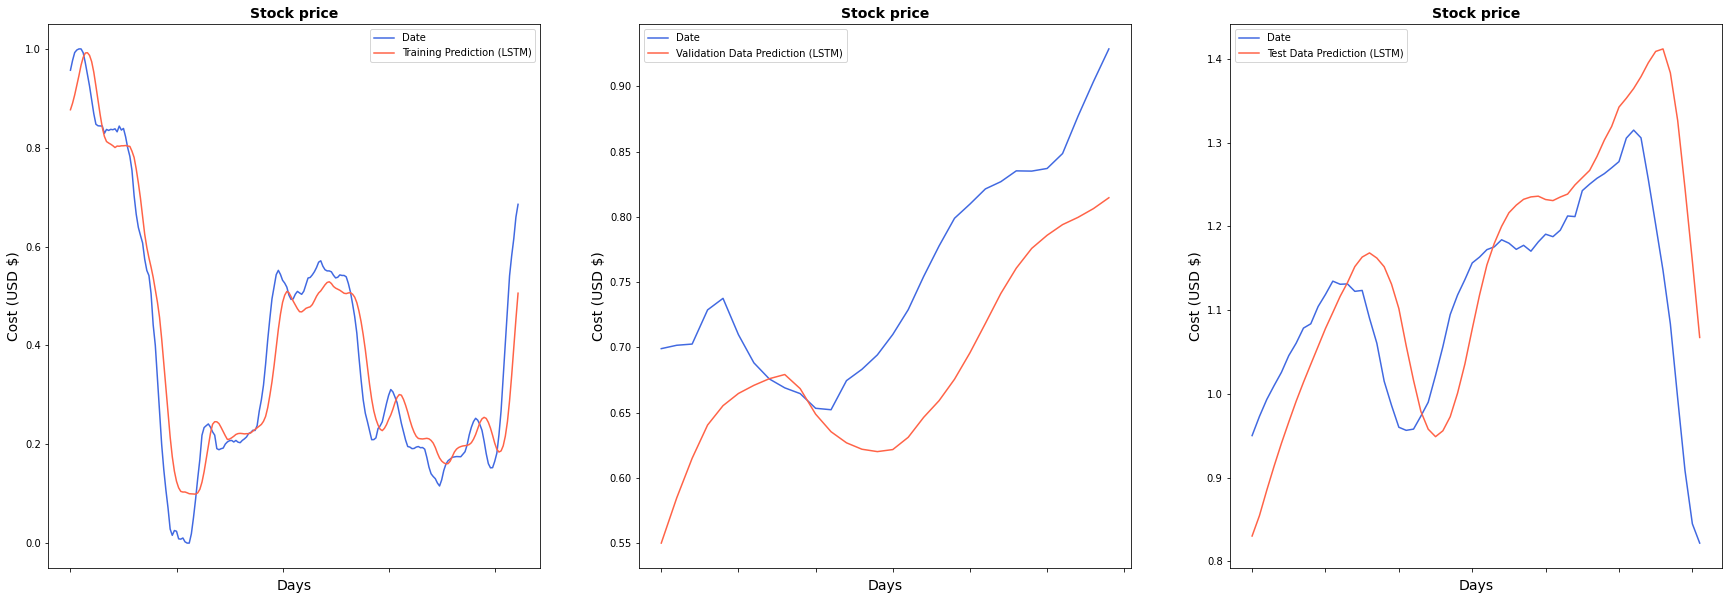

In [88]:
y_train_predict =model.predict(X_train)
y_val_predict =model.predict(X_val)
y_test_predict =model.predict(X_test)

plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)

In [89]:
predictions=np.concatenate([y_train_predict, y_val_predict, y_test_predict])

In [90]:
pred_prices = scaler_inverse(train_array=train["y"].values,
                            predictions=predictions)

,predicted,actuals,rolling_avg,rolling_std,Upper Band,Lower Band
0,19.593439,19.827143,20.381224,0.508127,21.397479,19.364969
1,19.570009,19.821429,20.353003,0.537387,21.427777,19.278229
2,19.541834,19.835714,20.318215,0.566958,21.452131,19.184299
3,19.565025,19.788571,20.278104,0.591167,21.460439,19.095770
4,19.562275,19.878571,20.230449,0.609175,21.448799,19.012099


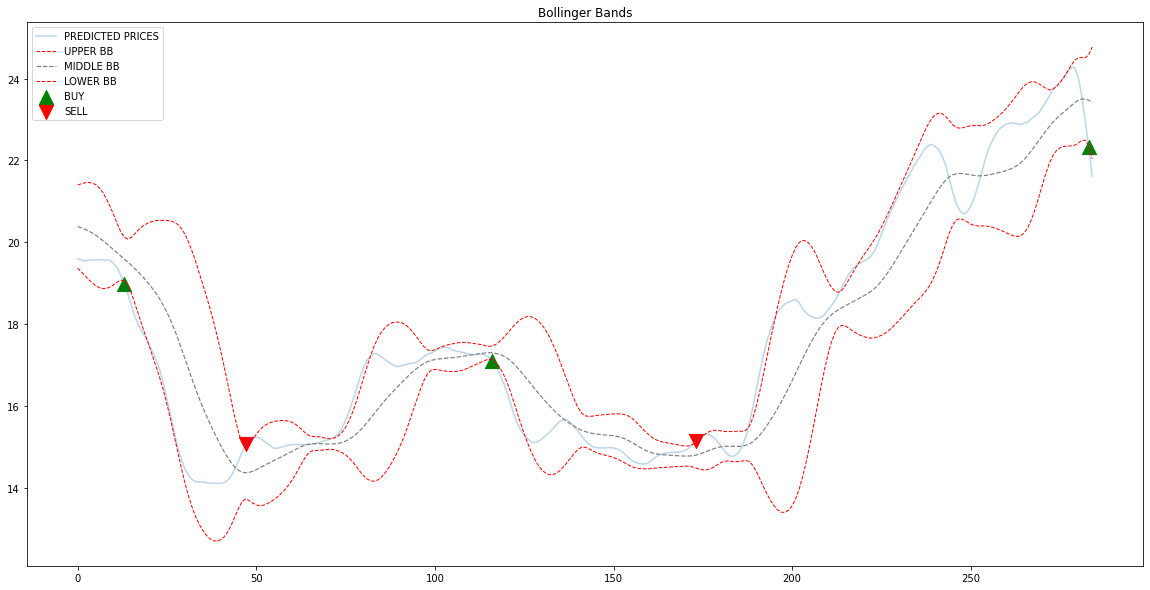

The actual returns had a value of -0.57% and the predicted returns had a value 10.43%


In [91]:
actuals=KCHOL_df_featured["y"].values
Bollinger_band = Bollinger_band_strategy(actuals, pred_prices, 20)